<a href="https://colab.research.google.com/github/adag21044/PoliticalTweetAnalyzer/blob/main/PoliticalTweetAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

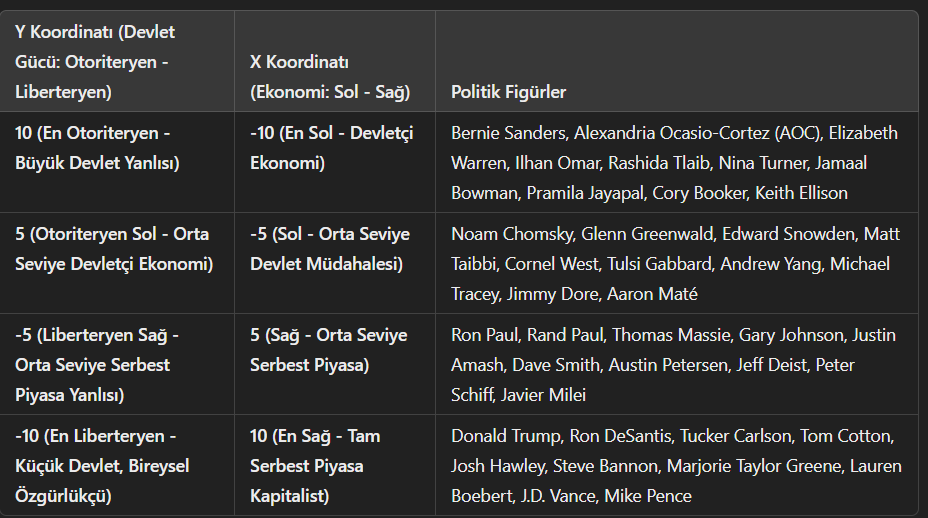

In [41]:
import re
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [42]:
# 1️⃣ **ÖRNEK POLİTİK VERİ SETİ**
tweets_data = {
    "authoritarian_left": [
        "The government must regulate businesses for fairness.",
        "We need higher taxes on the rich for wealth redistribution.",
        "Public healthcare is a human right, not a privilege.",
        "Strong government policies will protect the working class."
    ],
    "libertarian_left": [
        "People should be free to make their own life choices.",
        "The government should not interfere in personal matters.",
        "Decentralization of power is key to real freedom.",
        "We need a social safety net, but with personal choice."
    ],
    "authoritarian_right": [
        "Strong borders make a strong nation!",
        "Law and order must be strictly enforced.",
        "Traditional values should be the foundation of our society.",
        "Military strength is necessary for national security."
    ],
    "libertarian_right": [
        "The free market is the best path to economic growth.",
        "Less government regulation means more innovation.",
        "People should have full control over their private property.",
        "Taxation is theft! Government should be as small as possible."
    ]
}
test_tweets = [
    "We need higher taxes for the rich!",
    "Government control is too much, let people decide!",
    "America first! We must secure our borders."
]

In [43]:
# 2️⃣ **METİN TEMİZLEME**
def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet)
    tweet = re.sub(r"@\w+|#", "", tweet)
    tweet = re.sub(r"[^\w\s]", "", tweet)
    return tweet

for category in tweets_data:
    tweets_data[category] = [preprocess_tweet(tweet) for tweet in tweets_data[category]]

In [44]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")
bert_model = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base")

def get_bert_embedding(tweet):
    tokens = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True, max_length=50)
    with torch.no_grad():
        outputs = bert_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).numpy().flatten()  # 🟣 Mean Pooling daha stabil

In [45]:
# Politik görüşü net figürlerin tweetleri (tamamen elle)
datasets = {
    "(-10,10)": pd.DataFrame({   # Bernie Sanders
        "text": [
            "Healthcare is a human right.",
            "We must tax billionaires fairly.",
            "Workers deserve a living wage.",
            "Climate change is the greatest threat to humanity."
        ]
    }),
    "(-5,5)": pd.DataFrame({   # AOC
        "text": [
            "The Green New Deal is essential for our future.",
            "Public housing must be expanded and funded.",
            "Every American deserves dignified work and wages.",
            "We must challenge corporate power in Washington."
        ]
    }),
    "(5,-5)": pd.DataFrame({   # Justin Amash + Tulsi Gabbard
        "text": [
            # Justin Amash tweets
            "The government should be as small as possible.",
            "End the Fed and return fiscal responsibility.",
            "Taxation should be minimal and transparent.",
            "Personal freedoms are the foundation of a healthy society.",

            # Tulsi Gabbard tweets
            "Thank you for your leadership @realDonaldTrump.",
            "President Trump's commitment to heightened border security is making America safer.",
            "President Trump IS the President of Peace.",
            "Where Joe Biden failed, President Trump will succeed."
        ]
    }),
    "(10,-10)": pd.DataFrame({   # Donald Trump
        "text": [
            "We will build the wall and secure our borders.",
            "Make America Great Again!",
            "America First, always.",
            "Our military is stronger than ever before."
        ]
    })
}

# =====================
# GERÇEK DATASETLER (CSV)
# =====================

real_datasets = {
    "(-10,10)": pd.read_csv("/content/Bernie_tweets.csv", on_bad_lines="skip"),
    "(-5,5)": pd.read_csv("/content/aoc_tweets.csv", on_bad_lines="skip"),
    "(10,-10)": pd.read_csv("/content/trumptweets.csv", on_bad_lines="skip")
}

# Koordinatlar
point_map = {
    "(-10,10)": (-10, 10),
    "(-5,5)": (-5, 5),
    "(5,-5)": (5, -5),
    "(10,-10)": (10, -10)
}


In [48]:
X = []
y = []

for point, df in real_datasets.items():
    coords = point_map[point]
    if "text" in df.columns:
        tweets = df["text"].tolist()
    elif "Tweet" in df.columns:
        tweets = df["Tweet"].tolist()
    elif "body" in df.columns:
        tweets = df["body"].tolist()
    elif "content" in df.columns:
        tweets = df["content"].tolist()
    else:
        raise ValueError("Beklenen sütun bulunamadı (text, Tweet veya body)")

    for tweet in tqdm(tweets, desc=f"Embedding {point}"):
        cleaned = preprocess_tweet(tweet)
        embedding = get_bert_embedding(cleaned)
        X.append(embedding)
        y.append(coords)


Embedding (10,-10):  23%|██▎       | 9347/41122 [24:20<1:22:46,  6.40it/s]


KeyboardInterrupt: 

In [ ]:
# =====================
# 7️⃣ Democrat vs Republican CSV Dataset
# =====================

df_parties = pd.read_csv("/content/Democrat Vs. Republican Tweets.csv")

democrat_tweets = df_parties[df_parties["Party"] == "Democrat"]["Tweet"].tolist()
republican_tweets = df_parties[df_parties["Party"] == "Republican"]["Tweet"].tolist()

for tweet in tqdm(democrat_tweets, desc="Embedding Democrat (-5,5)"):
    cleaned = preprocess_tweet(tweet)
    embedding = get_bert_embedding(cleaned)
    X.append(embedding)
    y.append((-5, 5))  # ✅ Demokratlar -> Libertarian Left

for tweet in tqdm(republican_tweets, desc="Embedding Republican (5,-5)"):
    cleaned = preprocess_tweet(tweet)
    embedding = get_bert_embedding(cleaned)
    X.append(embedding)
    y.append((5, -5))  # ✅ Cumhuriyetçiler -> Libertarian Right

In [ ]:

X = np.array(X)
y = np.array(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

mlp = MLPRegressor(hidden_layer_sizes=(256, 128),
                   max_iter=1000,
                   early_stopping=True,
                   n_iter_no_change=10,
                   validation_fraction=0.1,
                   random_state=42)

mlp.fit(X, y)

print("✅ Model retrained with full dataset!")


Model eğitildi ✅


In [ ]:
# =====================
# 9️⃣ TEST TWEET
# =====================

my_tweet = "The government is getting too big and controlling everything."
cleaned_tweet = preprocess_tweet(my_tweet)
my_embedding = get_bert_embedding(cleaned_tweet).reshape(1, -1)
my_embedding = scaler.transform(my_embedding)

predicted_point = mlp.predict(my_embedding)[0]
print("Tahmin edilen pusula noktası:", predicted_point)

Tahmin edilen pusula noktası: [-0.37435111  0.29170875]


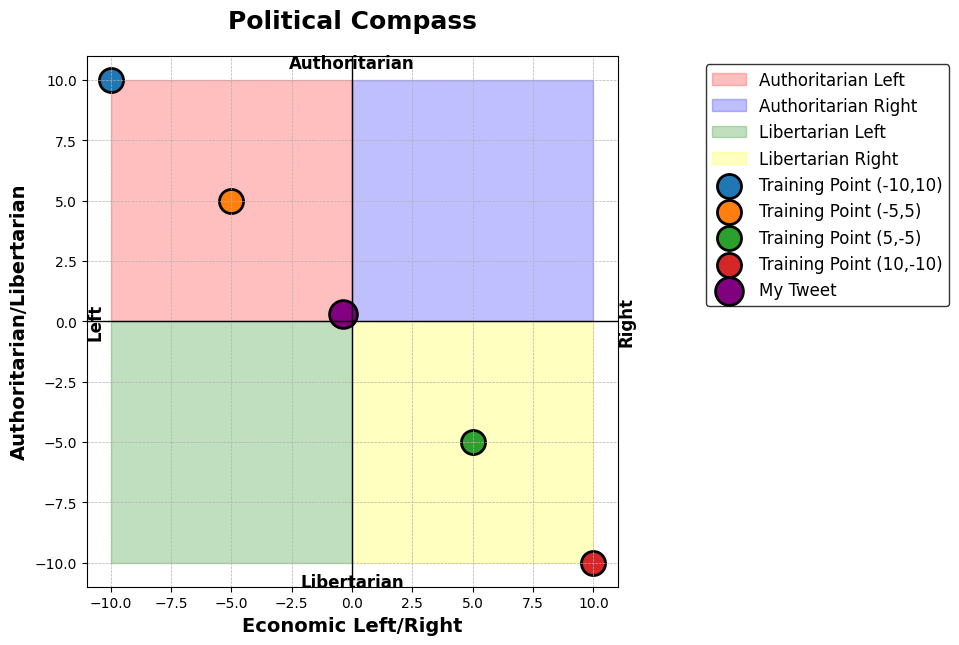

In [ ]:
# =====================
# 🔟 COMPASS (Visualization)
# =====================

plt.figure(figsize=(10, 10))
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)

plt.fill_between([-10, 0], 0, 10, color="red", alpha=0.25, label="Authoritarian Left")
plt.fill_between([0, 10], 0, 10, color="blue", alpha=0.25, label="Authoritarian Right")
plt.fill_between([-10, 0], -10, 0, color="green", alpha=0.25, label="Libertarian Left")
plt.fill_between([0, 10], -10, 0, color="yellow", alpha=0.25, label="Libertarian Right")

plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("Economic Left/Right", fontsize=14, fontweight="bold")
plt.ylabel("Authoritarian/Libertarian", fontsize=14, fontweight="bold")
plt.title("Political Compass (After Party Dataset)", fontsize=18, fontweight="bold", pad=20)

for point, (x, y) in point_map.items():
    plt.scatter(x, y, s=300, label=f"Training Point {point}", edgecolors="black", linewidth=2)

plt.scatter(predicted_point[0], predicted_point[1], s=400, color="purple", label="My Tweet", edgecolors="black", linewidth=2)

plt.text(0, 10.5, "Authoritarian", ha="center", fontsize=12, fontweight="bold")
plt.text(0, -11, "Libertarian", ha="center", fontsize=12, fontweight="bold")
plt.text(-11, 0, "Left", va="center", fontsize=12, fontweight="bold", rotation=90)
plt.text(11, 0, "Right", va="center", fontsize=12, fontweight="bold", rotation=90)

plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=12, frameon=True, edgecolor="black")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

Embedding Republican (5,5):  85%|████████▍ | 37630/44392 [1:32:57<16:24,  6.87it/s]